# UdaciMed | Notebook 2: Architecture Optimization

Welcome back to UdaciMed's optimization pipeline! In this notebook, you will implement hardware-aware architectural modifications to achieve our critical memory reduction goals.

### Recap: **Optimization challenge**

From [Notebook 1](01_baseline_analysis.ipynb), we identified that our ResNet-18 baseline model faces **memory, computation, speed, and throughput challenges**:

- **Target FLOP reduction**: >80% _(to achieve <0.4 GFLOPs per sample)_
- **Target memory usage**: <100MB 
- **Target throughput**: >2,000 samples/sec 
- **Target latency**: <3ms

while keeping **model sensitivity** >98%.

You have outlined an optimization strategy as part of your baseline model analysis, it is now time to develop the architectural optimizations.

### **Architecture optimization strategy**

You will implement and evaluate at least **3 architecture optimization techniques** out of the ones previously analyzed, as listed below:

1. Interpolation Removal
2. Depthwise Separable Convolution
3. Grouped Convolutions
4. Inverted Residual Blocks
5. Low-Rank Factorization
6. Channel Optimization
7. Parameter Sharing

Test all implemented techniques separately, and collect results. Then, decide the final optimization strategy (not all need to be enabled!) for the next phase.

---

Through this notebook, you will:
- **Implement >=3 optimization techniques** with modular toggles
- **Compare performance impacts** across memory, latency, FLOPs, and throughput
- **Validate clinical safety** by monitoring sensitivity metrics
- **Create an optimized model** with the most efficient architectural optimization settings

**Let's transform our baseline into a production-ready, memory-efficient diagnostic model!**

## Step 1: Setup and load baseline results

First, let's set up the environment and load our baseline model with analysis from Notebook 1.

In [1]:
# Make sure that libraries are dynamically re-loaded if changed
%load_ext autoreload
%autoreload 2

In [2]:
# Import core libraries
import torch
import torch.nn as nn
import numpy as np
import pickle
import os
import random
import copy
import matplotlib.pyplot as plt
from pprint import pprint
from torchsummary import summary
import warnings
warnings.filterwarnings('ignore')

# Import project utilities
from utils.data_loader import (
    load_pneumoniamnist,
    get_sample_batch
)
from utils.model import (
    create_baseline_model,
    get_model_info,
    train_baseline_model,
    plot_training_history
)
from utils.evaluation import (
    evaluate_with_multiple_thresholds
)
from utils.profiling import (
    PerformanceProfiler,
    measure_time
)
from utils.visualization import (
    plot_batch_size_comparison,
    plot_performance_profile,
    plot_operation_breakdown
)
from utils.architecture_optimization import (
    apply_interpolation_removal_optimization,
    apply_depthwise_separable_optimization,
    apply_grouped_convolution_optimization,
    apply_inverted_residual_optimization,
    apply_lowrank_factorization,
    apply_channel_optimization,
    apply_parameter_sharing,
    create_optimized_model
)

# Set the device for pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("WARNING: CUDA not available - optimization profiling will be limited")

print("Architecture optimization environment ready!")

Using device: cuda
GPU: Tesla T4
GPU Memory: 14.6 GB
Architecture optimization environment ready!


In [3]:
# Set random seed for reproducibility across optimization experiments
def set_deterministic_mode(seed=42):
    """
    Enable deterministic mode for consistent benchmarking.
    Critical for fair comparison between different techniques.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Disable for consistent timing
    os.environ["PYTHONHASHSEED"] = str(seed)

set_deterministic_mode(42)
print("Deterministic mode enabled for reproducible benchmarking")

Deterministic mode enabled for reproducible benchmarking


> **Why deterministic mode matters**
>
> Small variations in random initialization can make it difficult to assess the true impact of optimization techniques. Deterministic mode ensures that performance differences reflect architectural changes, not random variation.

In [4]:
# Updated targets based on baseline analysis findings
OPTIMIZATION_TARGETS = {
    'memory_mb': 100,                   # MB 
    'throughput_samples_sec': 2000,     # samples/sec
    'latency_ms': 3,                    # ms 
    'sensitivity_percent': 98,          # %
    'flop_reduction_percent': 80        # % 
}

print("Optimization targets for production deployment:")
for metric, target in OPTIMIZATION_TARGETS.items():
    print(f"   {metric.replace('_', ' ').title()}: {target}")

Optimization targets for production deployment:
   Memory Mb: 100
   Throughput Samples Sec: 2000
   Latency Ms: 3
   Sensitivity Percent: 98
   Flop Reduction Percent: 80


In [6]:
# Load baseline results from Notebook 1
try:
    with open('./results/baseline_results.pkl', 'rb') as f:
        baseline_results = pickle.load(f)
    
    print("Loaded baseline results from Notebook 1:")
    print(f"   Model: {baseline_results['model_name']}")
    print(f"   Parameters: {baseline_results['total_parameters']:,}")
    print(f"   Model Size: {baseline_results['model_size_mb']:.1f} MB")
    print(f"   Memory Usage: {baseline_results['memory']['peak_memory_mb']:.1f} MB")
    print(f"   Inference Time: {baseline_results['timing']['single_sample_ms']:.2f} ms")
    print(f"   Throughput: {baseline_results['timing']['batch_throughput_samples_per_sec']:.0f} samples/sec")
    print(f"   Clinical Sensitivity: {baseline_results['eval_results'][0.7]['recall']:.1%}")
    
except FileNotFoundError:
    print("ERROR: Baseline results not found. Please run Notebook 1 first.")
    raise

Loaded baseline results from Notebook 1:
   Model: ResNet-18 Baseline
   Parameters: 11,177,538
   Model Size: 42.6 MB
   Memory Usage: 330.5 MB
   Inference Time: 3.43 ms
   Throughput: 1259 samples/sec
   Clinical Sensitivity: 99.5%


In [7]:
# Recreate baseline model and load the trained weights
baseline_config = baseline_results['config']
baseline_model = create_baseline_model(
    num_classes=baseline_config['num_classes'], 
    input_size=baseline_config['image_size'], 
    pretrained=False
)

try:
    baseline_model.load_state_dict(torch.load('../results/best_baseline_model.pth', map_location=device))
    baseline_model = baseline_model.to(device)
    baseline_model.eval()
    print("Loaded trained baseline model successfully")
except FileNotFoundError:
    print("WARNING: Trained model weights not found. Using randomly initialized model.")
    baseline_model = baseline_model.to(device)

In [8]:
# Load test dataset for evaluation
test_loader = load_pneumoniamnist(
    split="test", 
    download=True, 
    size=baseline_config['image_size'], 
    batch_size=baseline_config['batch_size'],
    subset_size=baseline_config['subset_size'] * 0.15 if baseline_config['subset_size'] is not None else None
)

# Get sample batch for profiling
sample_images, sample_labels = get_sample_batch(test_loader)
sample_images = sample_images.to(device)
sample_labels = sample_labels.to(device)

print(f"Test data loaded: {sample_images.shape} batch for profiling")
print(f"   Batch memory footprint: {sample_images.numel() * sample_images.element_size() / 1024**2:.1f} MB")
print(f"   Class distribution: {sample_labels.sum().item()}/{len(sample_labels)} positive cases")

Using downloaded and verified file: /voc/work/.medmnist/pneumoniamnist_64.npz
Test data loaded: torch.Size([32, 3, 64, 64]) batch for profiling
   Batch memory footprint: 1.5 MB
   Class distribution: 23/32 positive cases


## Step 2: Configure optimization strategy

Define which optimizations to apply. 

Each technique can be independently enabled/disabled, allowing you to understand individual contributions and find the optimal combination for your use case.

In [9]:
# TODO: Configure your optimization strategy by setting each technique to True/False
# Experiment with different combinations to understand their individual and combined impacts

OPTIMIZATION_CONFIG = {
    # Enable/disable optimizations - start with one technique at a time for analysis
    'interpolation_removal': True,          # True/False - Add your value here
    'grouped_conv': False,                  # True/False - Add your value here
    'depthwise_separable': True,            # True/False - Add your value here
    'channel_optimization': False,          # True/False - Add your value here
    'inverted_residuals': False,            # True/False - Add your value here
    'lowrank_factorization': False,         # True/False - Add your value here
    'parameter_sharing': False,             # True/False - Add your value here
    
    # Execution parameters for training and inference
    'memory_format': torch.preserve_format, # [torch.preserve_format, torch.channels_last] - Add your value here
    'use_amp': False                        # True/False; Whether to use torch.cuda.amp - Add your value here
}

print("Optimization configuration:")
for technique, enabled in OPTIMIZATION_CONFIG.items():
    if isinstance(enabled, bool):
        status = "ENABLED" if enabled else "DISABLED"
        print(f"   {technique.replace('_', ' ').title()}: {status}")

Optimization configuration:
   Interpolation Removal: ENABLED
   Grouped Conv: DISABLED
   Depthwise Separable: ENABLED
   Channel Optimization: DISABLED
   Inverted Residuals: DISABLED
   Lowrank Factorization: DISABLED
   Parameter Sharing: DISABLED
   Use Amp: DISABLED


> **Tips for optimization strategy**: 
> 
> 1. Start with one technique at a time to understand individual contributions. 
> 2. Experiment with different optimization parameters by updating the parameters set in the optimization function calls in `create_optimized_model()` (less refactoring), or update `create_optimized_model()` to take parameters from _`OPTIMIZATION_CONFIG`_ and set them directly in the config (more seamless experimentation).

## Step 3: Apply architectural optimizations

Now let's create the optimized model by applying your selected techniques.

**IMPORTANT**: This is where most of your *TODOs* lie, as you need to implement optimization methods and pipeline in `utils/architecture_optimization.ipynb`. You can find hints in the functions' definitions within the utility script.

In [10]:
# TODO: Create the required optimization methods in `utils/architecture_optimization.ipynb`

print("Creating optimized model with selected techniques...")

# Apply optimizations using the architecture optimization utility in the correct order (some optimizations build on others)
# TODO: Complete the create_optimized_model() function in `utils/architecture_optimization.ipynb`
optimized_model = create_optimized_model(baseline_model, OPTIMIZATION_CONFIG)
optimized_model = optimized_model.to(device)

print("\nOptimized model created successfully!")
print(f"   Device: {next(optimized_model.parameters()).device}")

Creating optimized model with selected techniques...
Starting clinical model optimization pipeline...
   Applying interpolation removal optimization...
Applying native resolution optimization (64x64)...
INTERPOLATION REMOVAL completed.
   Applying depthwise separable optimization...
DEPTHWISE SEPARABLE completed: 16 replacements
Applied optimizations: interpolation_removal → depthwise_separable

Optimized model created successfully!
   Device: cuda:0


In [11]:
# Review new model architecture
summary(optimized_model, input_size=(3, baseline_config['image_size'], baseline_config["image_size"]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]             576
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]           4,096
       BatchNorm2d-9           [-1, 64, 16, 16]             128
DepthwiseSeparableConv2d-10           [-1, 64, 16, 16]               0
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]             576
      BatchNorm2d-14           [

> **How have the optimizations changed the expected model size in MB?**
> 
> Optimizations can either increase or decrease different memory components for the model. Use the above summary as a sanity check for your optimizations' implementations.

In [12]:
# Analyze the new memory footprint
def count_unique_parameters(model):
    """Count actual unique parameter tensors (shared params counted once)"""
    unique_params = {}
    total_params = 0
    
    for name, param in model.named_parameters():
        param_id = id(param)
        if param_id not in unique_params:
            unique_params[param_id] = {
                'tensor': param,
                'shape': param.shape,
                'elements': param.numel(),
                'first_seen': name,
                'shared_with': []
            }
        else:
            unique_params[param_id]['shared_with'].append(name)
    
    total_unique_elements = sum(info['elements'] for info in unique_params.values())
    
    return total_unique_elements, len(unique_params), unique_params

baseline_unique, baseline_objects, _ = count_unique_parameters(baseline_model)
optimized_unique, optimized_objects, optimized_params_details = count_unique_parameters(optimized_model)

baseline_state_size = sum(p.numel() for p in baseline_model.parameters())
optimized_state_size = sum(p.numel() for p in optimized_model.parameters())

print(f"Baseline model:")
print(f"   State dict size: {baseline_state_size:,} elements")
print(f"   Unique parameters: {baseline_unique:,} elements")

print(f"Optimized model:")
print(f"   State dict size: {optimized_state_size:,} elements")  # Remove the "(same as baseline)" text!
print(f"   Unique parameters: {optimized_unique:,} elements")

reduction = ((baseline_state_size - optimized_state_size) / baseline_state_size * 100)
print(f"Total parameter reduction: {reduction:.1f}%")

n_shared_params = sum([len(param_details['shared_with']) for param_id, param_details in optimized_params_details.items()])
print(f"# Shared parameters: {n_shared_params}")

Baseline model:
   State dict size: 11,177,538 elements
   Unique parameters: 11,177,538 elements
Optimized model:
   State dict size: 1,457,666 elements
   Unique parameters: 1,457,666 elements
Total parameter reduction: 87.0%
# Shared parameters: 0


> **Do you see the expected parameter reduction?**
> 
> The analysis above showcases both parameter reduction and parameter sharing (if applied). Optimizing model parameters directly contributes to memory savings, but remember: activation memory during inference often dominates, especially with larger input sizes!

## Step 4: Initialize optimized model via transfer learning

While we have changed the architecture, we can still transfer knowledge from the trained baseline model to our optimized architecture for any matching layers.

Preserving learned features where possible reduces retraining time and maintains clinical performance.

In [13]:
# Transfer compatible weights from baseline to optimized model
# This preserves learned features where possible, reducing retraining time

def transfer_compatible_weights(source_model, target_model):
    """
    Transfer weights from source model to target model where layer shapes match.
    This preserves learned representations in unmodified layers.
    """
    source_dict = dict(source_model.named_parameters())
    target_dict = dict(target_model.named_parameters())
    
    transferred_layers = []
    skipped_layers = []

    # TODO: Iterate through layers and define if they can be transferred or need skipping
    # Hint: After you match layers by name, what parameter attribute can you look at as a good proxy of whether the layer was updated?
    # Find a complete list of attributes at https://docs.pytorch.org/docs/stable/tensors.html#torch.Tensor

    # Add your code here
    
    return transferred_layers, skipped_layers

print("Transferring compatible weights from baseline to optimized model...")
transferred, skipped = transfer_compatible_weights(baseline_model, optimized_model)

print(f"\nTransferred {len(transferred)} compatible layers")
print(f"Skipped {len(skipped)} modified/new layers")

Transferring compatible weights from baseline to optimized model...

Transferred 0 compatible layers
Skipped 0 modified/new layers


## Step 5: Train/Fine-tune the optimized model

The optimized model needs training to learn the weights of new layers defined by the architectural changes.

If the number of new layers is low, keep in mind that lower learning rates can help preserve transferred knowledge while adapting to architectural changes for faster convergence.

In [14]:
# Load training data for fine-tuning the optimized model
# We need both training and validation data to fine-tune the model

train_loader = load_pneumoniamnist(
    split="train", 
    download=True, 
    size=baseline_config['image_size'], 
    batch_size=baseline_config['batch_size'],
    subset_size=baseline_config['subset_size'] * 0.7 if baseline_config['subset_size'] is not None else None
)

val_loader = load_pneumoniamnist(
    split="val", 
    download=True, 
    size=baseline_config['image_size'], 
    batch_size=baseline_config['batch_size'],
    subset_size=baseline_config['subset_size'] * 0.15 if baseline_config['subset_size'] is not None else None
)

print(f"Training data loaded:")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Image size: {baseline_config['image_size']}x{baseline_config['image_size']}")

Using downloaded and verified file: /voc/work/.medmnist/pneumoniamnist_64.npz
Using downloaded and verified file: /voc/work/.medmnist/pneumoniamnist_64.npz
Training data loaded:
   Training batches: 148
   Validation batches: 17
   Image size: 64x64


In [18]:
# TODO: Configure training parameters
# Feel free to update the training regime (learning rate scheduler, optimizer, regularization, ...) in the train_baseline_model() method of `util/model.py`, if desired

FINE_TUNING_CONFIG = {
    'num_epochs': 5,              
    'learning_rate': 0.0001,      
    'lr_step_size': 2,           
    'weight_decay': 1e-4,        
    'patience': 3                 
}


print("Fine-tuning configuration:")
for key, value in FINE_TUNING_CONFIG.items():
    print(f"   {key}: {value}")

Fine-tuning configuration:
   num_epochs: 5
   learning_rate: 0.0001
   lr_step_size: 2
   weight_decay: 0.0001
   patience: 3


Fine-tuning optimized model...
Starting baseline model training for pneumonia detection...
   Config: 5 epochs, lr=0.0001, wd=0.0001


Epoch 1/5 [Train]:   0%|                                                    | 0/148 [00:00<?, ?it/s]

   Epoch  1: Train Acc  87.7% | Val Acc  90.3% | Train Loss 0.2891 | Val Loss 0.2182 | LR 0.000100
      New best model saved (Val Acc: 90.3%)


   Epoch  2: Train Acc  92.7% | Val Acc  93.1% | Train Loss 0.1899 | Val Loss 0.1827 | LR 0.000100
      New best model saved (Val Acc: 93.1%)


   Epoch  3: Train Acc  93.4% | Val Acc  93.5% | Train Loss 0.1657 | Val Loss 0.1763 | LR 0.000010
      New best model saved (Val Acc: 93.5%)


   Epoch  4: Train Acc  94.4% | Val Acc  94.5% | Train Loss 0.1463 | Val Loss 0.1532 | LR 0.000010
      New best model saved (Val Acc: 94.5%)


   Epoch  5: Train Acc  94.5% | Val Acc  93.9% | Train Loss 0.1416 | Val Loss 0.1522 | LR 0.000001
Training completed! Best validation accuracy: 94.47%


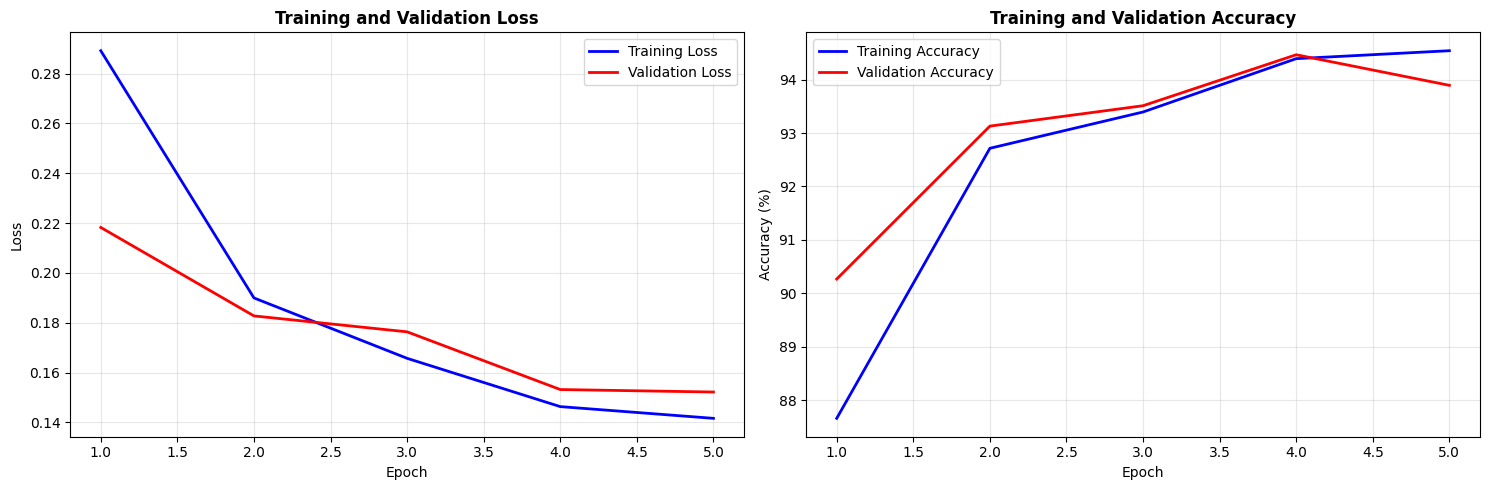


Training Summary:
   Best Validation Accuracy: 94.5%
   Total Epochs: 5
   Final Training Accuracy: 94.5%
   Final Validation Accuracy: 93.9%


In [19]:
# Train/Fine-tune the optimized model
print("Fine-tuning optimized model...")
optimized_model, fine_tuning_history = train_baseline_model(
    optimized_model, train_loader, val_loader, device, FINE_TUNING_CONFIG, save_path="./results/optimized_model.pth",
)

# Plot fine-tuning progress
plot_training_history(fine_tuning_history)

> **_Indicators of training success_**:
> 
> - **Validation accuracy** should recover to within 1-2% of baseline (target: >98%)
> - **Training should converge quickly** (2-5 epochs), especially with transferred weights
> - **Loss curves should be smooth** without significant overfitting
> 
> If training struggles, consider: reducing learning rate, increasing epochs, or simplifying optimizations.

## Step 6: Evaluate clinical performance

Critical step: validate that optimizations maintain clinical safety standards.

In [20]:
# Evaluate clinical performance of the optimized model
print("Evaluating clinical performance of optimized model...")

# Evaluate optimized model
# TODO: Choose the classification thresholds to test
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]  # Add your values here
eval_results = evaluate_with_multiple_thresholds(optimized_model, test_loader, device, thresholds)

# TODO: Choose the classification threshold for final optimized metrics
# Hint: sensitivity >98% should be a must, but also balance specificity to minimize false positives
optimized_classification_threshold = 0.4  # Add your value here 
optimized_metrics = eval_results[optimized_classification_threshold]

Evaluating clinical performance of optimized model...

Evaluating with threshold 0.3:
Clinical Evaluation Results (threshold: 0.300):
   Accuracy:  77.2%
   Precision: 73.8% (PPV - Positive Predictive Value)
   Recall:    98.7% (Sensitivity)
   F1 Score:  84.4%
   AUC-ROC:   0.922

Confusion Matrix Analysis:
   True Negatives (Normal correctly identified):      97
   False Positives (Normal misclassified):           137
   False Negatives (Pneumonia missed):                 5
   True Positives (Pneumonia correctly detected):   385

Clinical Performance Interpretation:
   Sensitivity (True Positive Rate):     98.7% (detects 98.7% of pneumonia cases)
   Specificity (True Negative Rate):     41.5% (correctly identifies 41.5% of normal cases)
   PPV (Positive Predictive Value):      73.8% (when model predicts pneumonia, it's correct 73.8% of time)
   NPV (Negative Predictive Value):      95.1% (when model predicts normal, it's correct 95.1% of time)

Clinical Significance:
   False Negativ

In [21]:
# Compare optimized model performance against baseline

# TODO: Choose the classification threshold for baseline optimized metrics
baseline_classification_thr = 0.7 # Add your value here
baseline_metrics = baseline_results['eval_results'][baseline_classification_thr]

print("BASELINE vs OPTIMIZED PERFORMANCE COMPARISON:")
print(f"\n   Sensitivity (Recall):")
print(f"     Baseline:  {baseline_metrics['recall']:.1%}")
print(f"     Optimized: {optimized_metrics['recall']:.1%}")
sensitivity_change = (optimized_metrics['recall'] - baseline_metrics['recall']) * 100
print(f"     Change:    {sensitivity_change:+.1f} percentage points")

print(f"\n   Overall Accuracy:")
print(f"     Baseline:  {baseline_metrics['accuracy']:.1%}")
print(f"     Optimized: {optimized_metrics['accuracy']:.1%}")
accuracy_change = (optimized_metrics['accuracy'] - baseline_metrics['accuracy']) * 100
print(f"     Change:    {accuracy_change:+.1f} percentage points")

print(f"\n   AUC-ROC:")
print(f"     Baseline:  {baseline_metrics['auc']:.3f}")
print(f"     Optimized: {optimized_metrics['auc']:.3f}")
auc_change = optimized_metrics['auc'] - baseline_metrics['auc']
print(f"     Change:    {auc_change:+.3f}")

# Clinical safety assessment
print(f"\nCLINICAL SAFETY ASSESSMENT:")
optimized_sensitivity = optimized_metrics['recall']
if optimized_sensitivity >= 0.98:
    print(f"   SAFE: Sensitivity {optimized_sensitivity:.1%} meets clinical requirement (>98%)")
else:
    print(f"   WARNING: Sensitivity {optimized_sensitivity:.1%} below clinical requirement (>98%)")
    print(f"   RECOMMENDATION: Reduce optimization aggressiveness or retrain with sensitivity focus")

if abs(accuracy_change) <= 2.0:
    print(f"   ACCEPTABLE: Accuracy change {accuracy_change:+.1f}% within tolerance (±2%)")
else:
    print(f"   CAUTION: Accuracy change {accuracy_change:+.1f}% exceeds tolerance (±2%)")

BASELINE vs OPTIMIZED PERFORMANCE COMPARISON:

   Sensitivity (Recall):
     Baseline:  99.5%
     Optimized: 98.7%
     Change:    -0.8 percentage points

   Overall Accuracy:
     Baseline:  88.1%
     Optimized: 79.6%
     Change:    -8.5 percentage points

   AUC-ROC:
     Baseline:  0.966
     Optimized: 0.922
     Change:    -0.044

CLINICAL SAFETY ASSESSMENT:
   SAFE: Sensitivity 98.7% meets clinical requirement (>98%)
   CAUTION: Accuracy change -8.5% exceeds tolerance (±2%)


## Step 7: Profile optimized model performance

Now let's measure the performance improvements from our optimizations.

Quantifying improvements validates that optimizations achieve their intended benefits and helps prioritize techniques for future projects.

In [22]:
# Profile the optimized model's inference performance
print("Profiling optimized model performance...")

# Initialize profiler
profiler = PerformanceProfiler(device=str(device), use_amp=OPTIMIZATION_CONFIG["use_amp"])

# Profile timing
optimized_timing = profiler.profile_inference_time(
    model=optimized_model,
    input_tensor=sample_images,
    num_runs=100,
    warmup_runs=10
)

print(f"\nTIMING RESULTS:")
print(f"   Single Sample Latency: {optimized_timing['single_sample_ms']:.2f} ms")
print(f"   Batch Throughput: {optimized_timing['batch_throughput_samples_per_sec']:.0f} samples/sec")
print(f"   Mean Inference Time: {optimized_timing['mean_ms']:.2f} ms")
print(f"   95th Percentile: {optimized_timing['p95_ms']:.2f} ms")

Profiling optimized model performance...

TIMING RESULTS:
   Single Sample Latency: 4.54 ms
   Batch Throughput: 6790 samples/sec
   Mean Inference Time: 4.54 ms
   95th Percentile: 4.66 ms


In [23]:
# Profile FLOPs of the optimized model
optimized_flops = profiler.profile_flops(
    model=optimized_model, 
    input_tensor=sample_images
)

if 'error' not in optimized_flops:
    print(f"\nFLOPs Results:")
    print(f"   Total: {optimized_flops['total_gflops']:.2f} GFLOPs")
    print(f"   Per Sample: {optimized_flops['gflops_per_sample']:.2f} GFLOPs")
    if 'module_percentage' in optimized_flops and optimized_flops['module_percentage']:
        print(f"\n   Top Operations (by FLOPs):")
        for module, percentage in list(optimized_flops['module_percentage'].items())[:5]:
            gflops = optimized_flops['module_breakdown_gflops'][module]
            print(f"     {module}: {percentage:.1f}% ({gflops:.2f} GFLOPs)")
else:
    print(f"WARNING: FLOPs calculation failed: {optimized_flops['error']}")
    optimized_flops = {}

Unsupported operator aten::max_pool2d encountered 1 time(s)
Unsupported operator aten::add_ encountered 8 time(s)



FLOPs Results:
   Total: 0.91 GFLOPs
   Per Sample: 0.03 GFLOPs

   Top Operations (by FLOPs):
     conv: 96.9% (0.88 GFLOPs)
     batch_norm: 3.1% (0.03 GFLOPs)
     adaptive_avg_pool2d: 0.0% (0.00 GFLOPs)
     linear: 0.0% (0.00 GFLOPs)


In [24]:
# Profile memory usage of the optimized model
optimized_memory = profiler.profile_memory_usage(
    model=optimized_model,
    input_tensor=sample_images
)

if 'error' not in optimized_memory:
    print(f"\nMEMORY RESULTS:")
    print(f"   Peak Memory: {optimized_memory['peak_memory_mb']:.1f} MB")
    print(f"   Memory Increase: {optimized_memory['memory_increase_mb']:.1f} MB")
    
    if 'component_breakdown' in optimized_memory:
        components = optimized_memory['component_breakdown']
        print(f"\n   Memory Component Breakdown:")
        for component, usage in components.items():
            print(f"     {component.replace('_', ' ').title()}: {usage:.1f} MB")
else:
    print(f"WARNING: Memory profiling error: {optimized_memory['error']}")
    optimized_memory = {}


MEMORY RESULTS:
   Peak Memory: 88.3 MB
   Memory Increase: 16.0 MB

   Memory Component Breakdown:
     Model Parameters Mb: 5.6 MB
     Input Tensor Mb: 1.5 MB
     Output Tensor Mb: 0.0 MB
     Activations Mb: 14.5 MB


In [25]:
# Compare performance improvements against baseline to validate progress toward optimization targets

# Get baseline performance metrics
baseline_timing = baseline_results['timing']
baseline_memory = baseline_results['memory']
baseline_flops = baseline_results['flops']

print("PERFORMANCE IMPROVEMENT ANALYSIS:")

# Timing improvements
latency_improvement = baseline_timing['single_sample_ms'] / optimized_timing['single_sample_ms']
throughput_improvement = optimized_timing['batch_throughput_samples_per_sec'] / baseline_timing['batch_throughput_samples_per_sec']

print(f"\nSpeed Improvements:")
print(f"   Latency Speedup: {latency_improvement:.2f}x ({baseline_timing['single_sample_ms']:.2f}ms → {optimized_timing['single_sample_ms']:.2f}ms)")

# Memory improvements
if 'error' not in optimized_memory and 'error' not in baseline_memory:
    memory_reduction = (baseline_memory['peak_memory_mb'] - optimized_memory['peak_memory_mb']) / baseline_memory['peak_memory_mb'] * 100
    print(f"\n Memory Improvements:")
    print(f"   Memory Reduction: {memory_reduction:.1f}% ({baseline_memory['peak_memory_mb']:.1f}MB → {optimized_memory['peak_memory_mb']:.1f}MB)")
    
    # Check target progress
    if optimized_memory['peak_memory_mb'] <= OPTIMIZATION_TARGETS['memory_mb']:
        print(f"   TARGET ACHIEVED: {optimized_memory['peak_memory_mb']:.1f}MB ≤ {OPTIMIZATION_TARGETS['memory_mb']}MB")
    else:
        remaining_reduction = optimized_memory['peak_memory_mb'] - OPTIMIZATION_TARGETS['memory_mb']
        print(f"   TARGET PROGRESS: {remaining_reduction:.1f}MB reduction still needed")

# Throughput target check
print(f"\nThroughput Improvements:")
throughput_target_met = "TARGET ACHIEVED" if optimized_timing['batch_throughput_samples_per_sec'] >= OPTIMIZATION_TARGETS['throughput_samples_sec'] else "WARNING: TARGET IN PROGRESS"
print(f"   Throughput Gain: {throughput_improvement:.2f}x ({baseline_timing['batch_throughput_samples_per_sec']:.0f} → {optimized_timing['batch_throughput_samples_per_sec']:.0f} samples/sec)")
print(f"   Throughput Target: {throughput_target_met} ({optimized_timing['batch_throughput_samples_per_sec']:.0f} vs {OPTIMIZATION_TARGETS['throughput_samples_sec']} target)")

# Expected FLOP reduction (based on optimizations applied)
print(f"\nEstimated FLOP Reduction:")
new_ = optimized_flops['total_gflops']

flop_reduction_percent = (1 - (optimized_flops['total_gflops'] / baseline_flops['total_gflops'])) * 100
flop_target_met = "TARGET ACHIEVED" if flop_reduction_percent >= OPTIMIZATION_TARGETS['flop_reduction_percent'] else "WARNING: TARGET IN PROGRESS"
print(f"   FLOP Target: {flop_target_met} ({flop_reduction_percent:.2f} vs {OPTIMIZATION_TARGETS['flop_reduction_percent']})")


PERFORMANCE IMPROVEMENT ANALYSIS:

Speed Improvements:
   Latency Speedup: 0.76x (3.43ms → 4.54ms)

 Memory Improvements:
   Memory Reduction: 73.3% (330.5MB → 88.3MB)
   TARGET ACHIEVED: 88.3MB ≤ 100MB

Throughput Improvements:
   Throughput Gain: 5.39x (1259 → 6790 samples/sec)
   Throughput Target: TARGET ACHIEVED (6790 vs 2000 target)

Estimated FLOP Reduction:
   FLOP Target: TARGET ACHIEVED (98.44 vs 80)


> **What if you are missing some targets, but you are confident that your optimization strategy and implementation are sound?**
> 
> If you almost hit deployment targets + maintain clinical safety, proceed to Notebook 3. Hardware deployment often closes the remaining gaps!
> If your clinical safety is slightly below threshold and you have already spent too much time trying to parameter tune, summarize what you'd do to hit this target with more time in the final markdown section here and proceed to Notebook 3.

   Profiling multiple batch sizes...


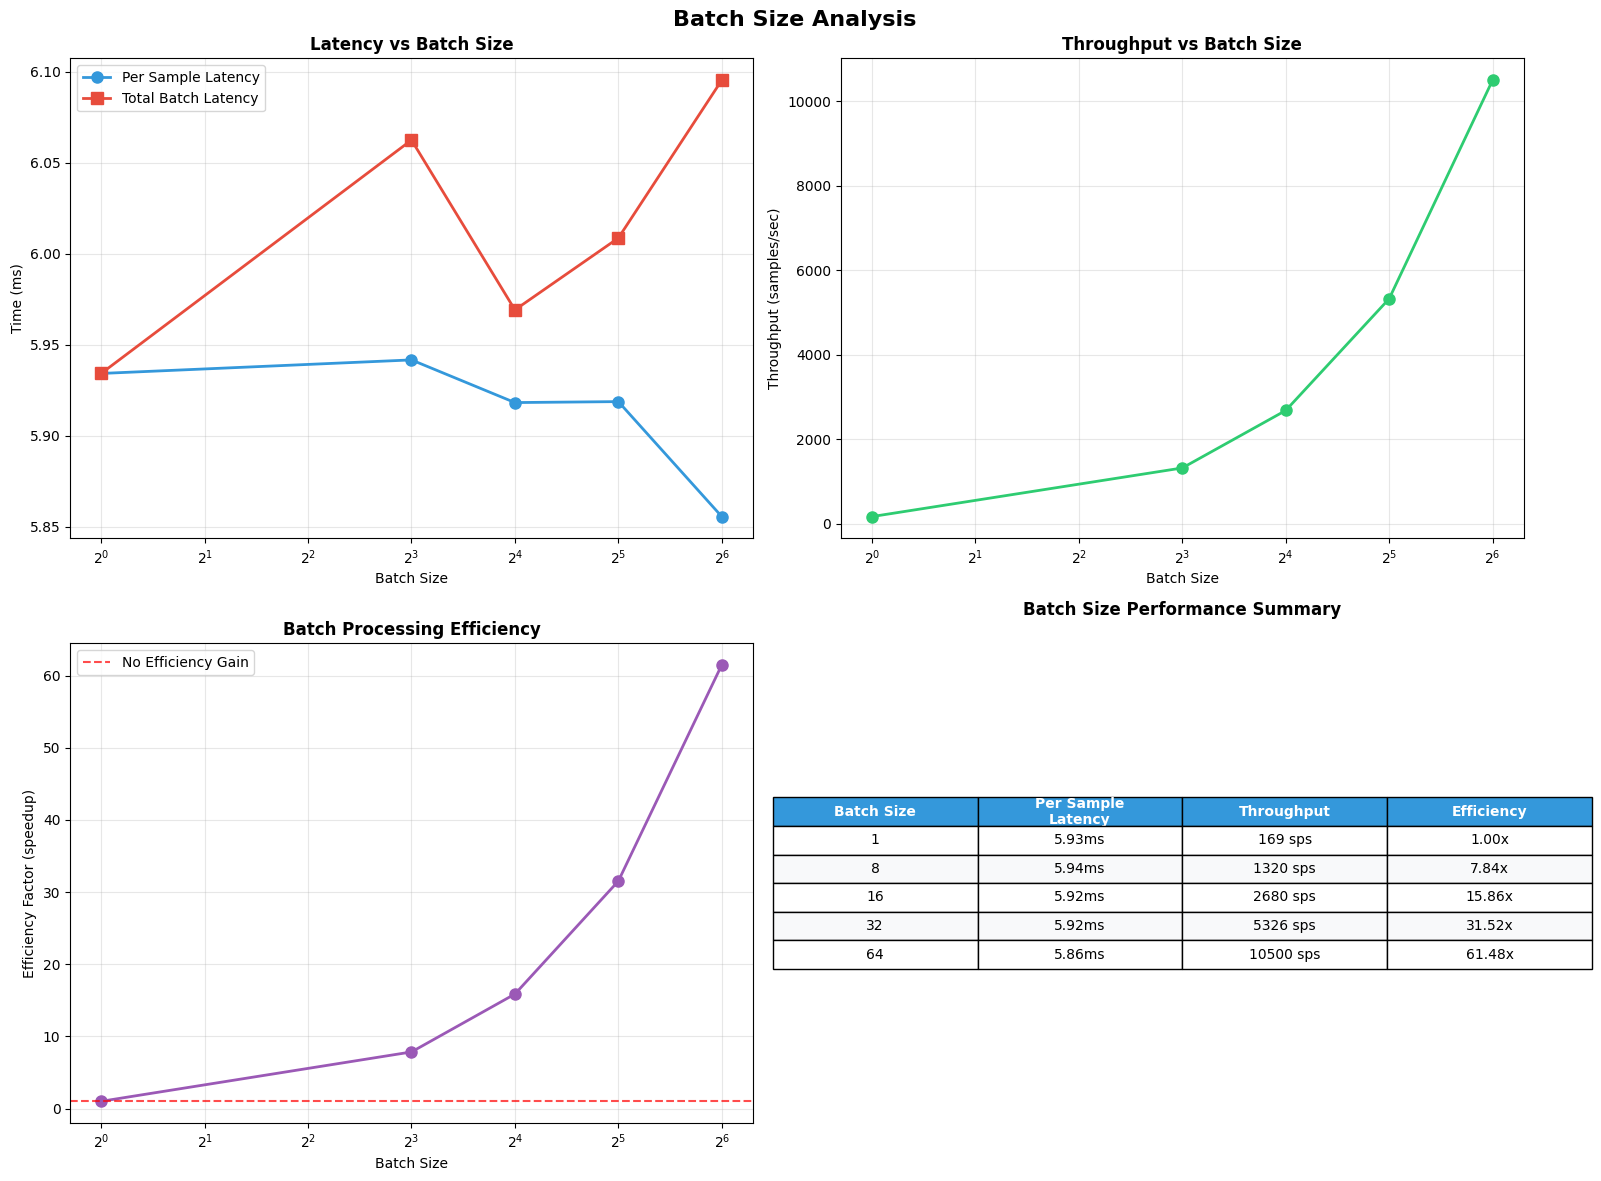

In [30]:
# Profile performance with different batch sizes
# TODO: Choose the batch sizes appropriate for T4 memory constraints
batch_sizes =[1, 8, 16, 32, 64] # Add your values here

print("   Profiling multiple batch sizes...")
batch_results = profiler.profile_multiple_batch_sizes(
    optimized_model, sample_images.shape, batch_sizes
)

# Visualize batch size analysis for deployment understanding
plot_batch_size_comparison(batch_results)

## Step 8: Visualize performance improvements

Create visual comparisons to understand the optimization impact.

Visual analysis helps identify bottlenecks, validate improvements, and communicate results to stakeholders who may not be familiar with raw performance metrics.

Generating performance visualizations...


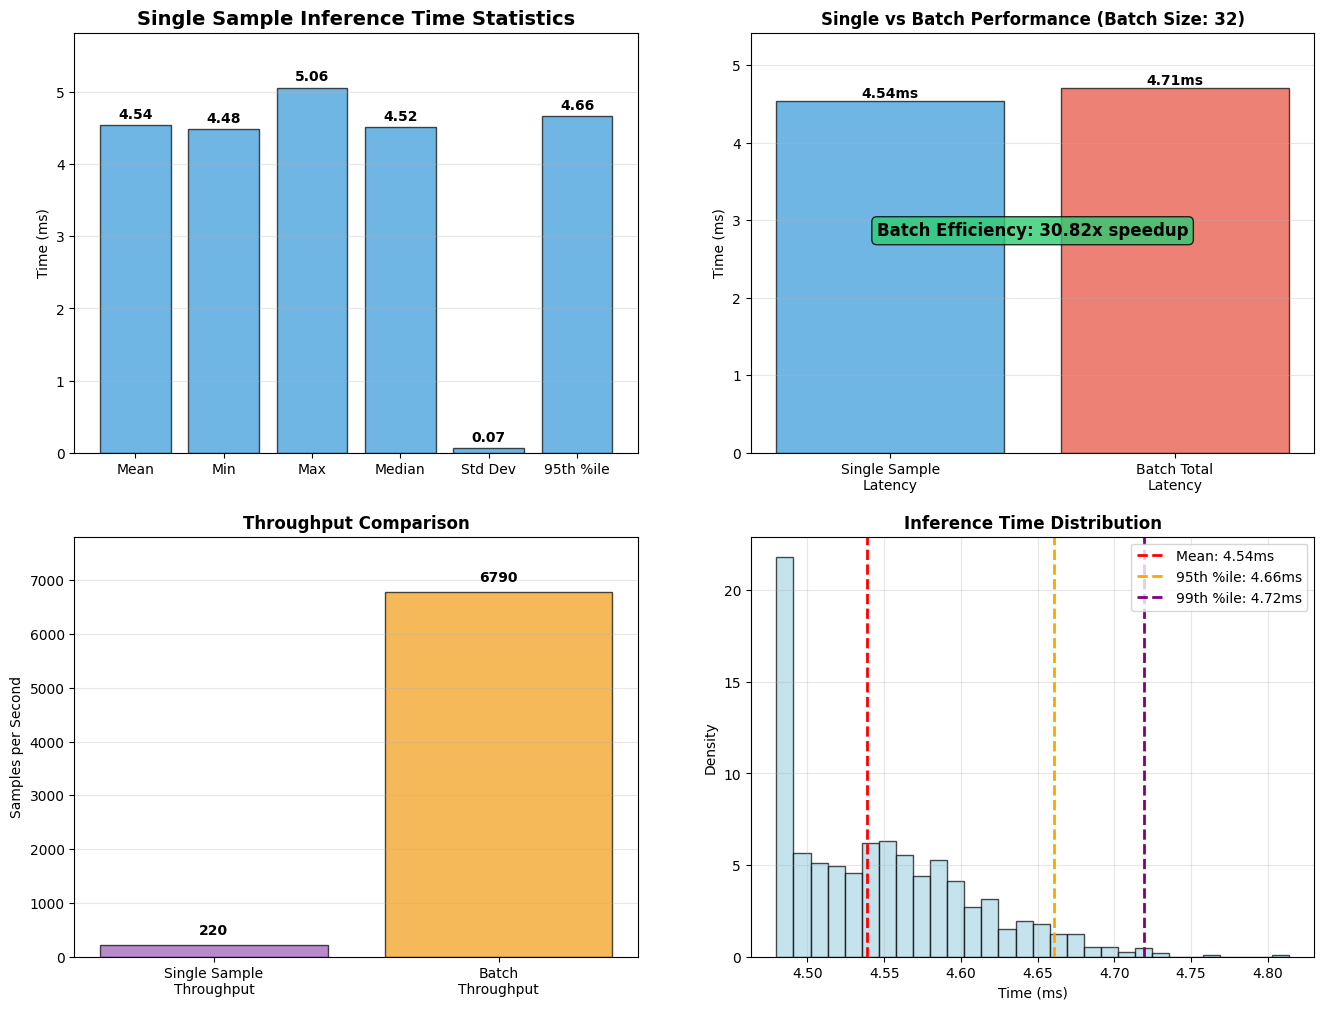

In [31]:
# Visualize the optimized model's performance profile, useful to understand where the performance gains come from

print("Generating performance visualizations...")
plot_performance_profile(optimized_timing)

Analyzing operation distribution changes...


STAGE:2025-09-19 00:42:33 1760:1760 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-09-19 00:42:33 1760:1760 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-09-19 00:42:33 1760:1760 ActivityProfilerController.cpp:324] Completed Stage: Post Processing



Optimized Model Operation Breakdown:
   Convolution Ops: 44.5%
   Normalization Ops: 29.4%
   Other Ops: 13.4%
   Activation Ops: 9.7%
   Pooling Ops: 1.7%
   Matrix Multiply Ops: 1.1%


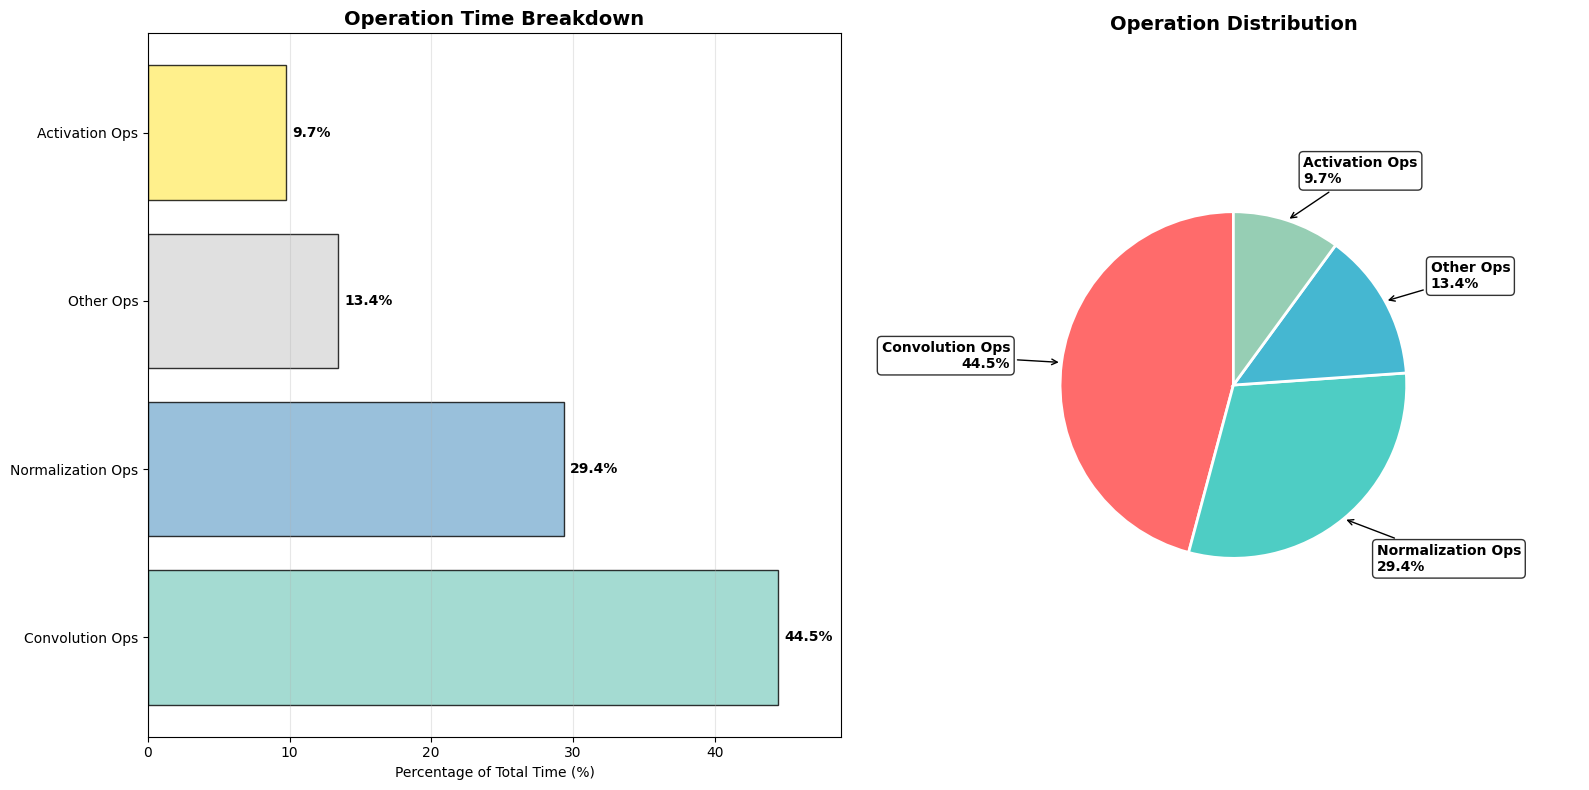

In [32]:
# Create a detailed operation breakdown for the optimized model
print("Analyzing operation distribution changes...")
optimized_detailed = profiler.profile_with_pytorch_profiler(
    model=optimized_model,
    input_tensor=sample_images,
    num_steps=10
)

if 'error' not in optimized_detailed and 'operation_breakdown' in optimized_detailed:
    print("\nOptimized Model Operation Breakdown:")
    op_breakdown = optimized_detailed['operation_breakdown']
    
    # Show top operations, if they contribute to at least 1% of operations
    sorted_ops = sorted(op_breakdown.items(), key=lambda x: x[1], reverse=True)
    for op_type, percentage in sorted_ops:
        if percentage > 1: 
            print(f"   {op_type.replace('_', ' ').title()}: {percentage:.1f}%")
    
    # Visualize operation breakdown
    plot_operation_breakdown(op_breakdown)
else:
    print("WARNING: Operation breakdown visualization not available")

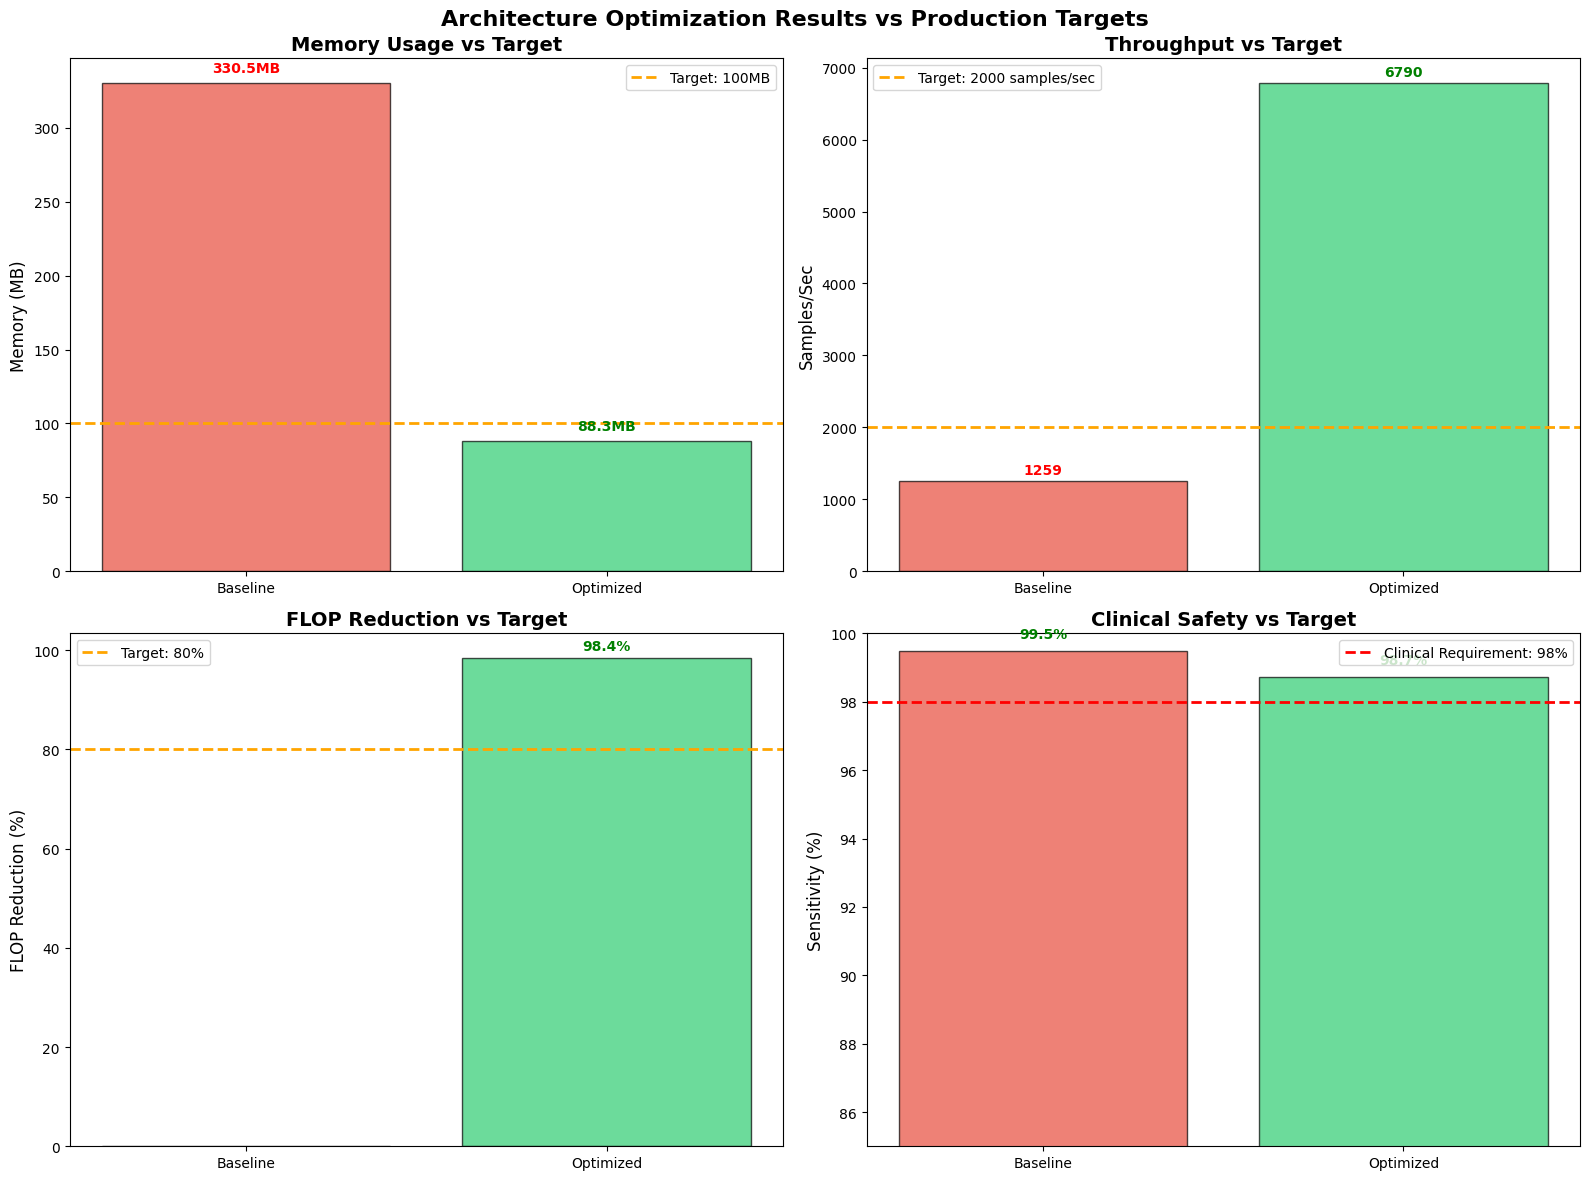

In [33]:
# Create a comprehensive comparison visualization of before/after metrics

# Create comparison chart
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Memory Usage with Target Line
models = ['Baseline', 'Optimized']
if 'error' not in optimized_memory:
    # TODO: Extract baseline and optimized models' memory 
    # HINT: Which values should you select from baseline_memory and optimized_memory? They should match by name!
    memories = [
    baseline_memory['peak_memory_mb'], 
    optimized_memory['peak_memory_mb']
]
  # Add your values here
    colors = ['#e74c3c', '#2ecc71'] 
    
    bars = ax1.bar(models, memories, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
    ax1.set_title('Memory Usage vs Target', fontweight='bold', fontsize=14)
    ax1.set_ylabel('Memory (MB)', fontsize=12)
    ax1.axhline(y=OPTIMIZATION_TARGETS['memory_mb'], color='orange', linestyle='--', linewidth=2, label=f'Target: {OPTIMIZATION_TARGETS["memory_mb"]}MB')
    ax1.legend(fontsize=10)
    
    for bar, memory in zip(bars, memories):
        color = 'green' if memory <= OPTIMIZATION_TARGETS['memory_mb'] else 'red'
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f'{memory:.1f}MB', ha='center', va='bottom', fontweight='bold', color=color)

# 2. Throughput with Target Line  
# TODO: Extract baseline and optimized models' throughput
# HINT: Which values should you select from baseline_timing and optimized_timing? They should match by name!
throughputs = [
    baseline_timing['batch_throughput_samples_per_sec'],
    optimized_timing['batch_throughput_samples_per_sec']
]
  # Add your values here
bars = ax2.bar(models, throughputs, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
ax2.set_title('Throughput vs Target', fontweight='bold', fontsize=14)
ax2.set_ylabel('Samples/Sec', fontsize=12)
ax2.axhline(y=OPTIMIZATION_TARGETS['throughput_samples_sec'], color='orange', linestyle='--', linewidth=2, label=f'Target: {OPTIMIZATION_TARGETS["throughput_samples_sec"]} samples/sec')
ax2.legend(fontsize=10)

for bar, throughput in zip(bars, throughputs):
    color = 'green' if throughput >= OPTIMIZATION_TARGETS['throughput_samples_sec'] else 'red'
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{throughput:.0f}', ha='center', va='bottom', fontweight='bold', color=color)

# 3. FLOP Reduction (if available)
# TODO: Extract target and optimized model's flops reduction (%)
# HINT: Which values should you select from OPTIMIZATION_TARGETS and where did we define flop reduction for the optimized model?
flop_data = [
    0,  # Baseline (no reduction)
    flop_reduction_percent  # Calculated earlier in the notebook
]
   # Add your values here
bars = ax3.bar(models, flop_data, color=['#95a5a6', colors[1]], alpha=0.7, edgecolor='black', linewidth=1)
ax3.set_title('FLOP Reduction vs Target', fontweight='bold', fontsize=14)
ax3.set_ylabel('FLOP Reduction (%)', fontsize=12)
ax3.axhline(y=OPTIMIZATION_TARGETS['flop_reduction_percent'], color='orange', linestyle='--', linewidth=2, label=f'Target: {OPTIMIZATION_TARGETS["flop_reduction_percent"]}%')
ax3.legend(fontsize=10)

for bar, flop_red in zip(bars, flop_data):
    if flop_red > 0:
        color = 'green' if flop_red >= OPTIMIZATION_TARGETS['flop_reduction_percent'] else 'red'
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{flop_red:.1f}%', ha='center', va='bottom', fontweight='bold', color=color)

# 4. Clinical Performance with Target Line
# TODO: Extract baseline and optimized models' sensitivities
# HINT: Which values should you select from baseline_metrics and optimized_metrics? They should match by name!
sensitivities = [
    baseline_metrics['recall'] * 100,  # Convert to percentage
    optimized_metrics['recall'] * 100
]
  # Add your values here
bars = ax4.bar(models, sensitivities, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
ax4.set_title('Clinical Safety vs Target', fontweight='bold', fontsize=14)
ax4.set_ylabel('Sensitivity (%)', fontsize=12)
ax4.set_ylim(85, 100)
ax4.axhline(y=OPTIMIZATION_TARGETS['sensitivity_percent'], color='red', linestyle='--', linewidth=2, label=f'Clinical Requirement: {OPTIMIZATION_TARGETS["sensitivity_percent"]}%')
ax4.legend(fontsize=10)

for bar, sensitivity in zip(bars, sensitivities):
    color = 'green' if sensitivity >= OPTIMIZATION_TARGETS['sensitivity_percent'] else 'red'
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            f'{sensitivity:.1f}%', ha='center', va='bottom', fontweight='bold', color=color)

plt.suptitle('Architecture Optimization Results vs Production Targets', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
plt.show()

## Step 9: Save optimized model's performance

Save the optimized model performance results for future reference, both at deployment planning and for future optimization iterations.

In [36]:
# Save the optimized model weights and optimization results

# TODO: Choose a meaningful name for the experiment, which will be used as part of the filename for the results
# Hint: Consider having the optimizations applied explicitly mentioned within the experiment name
experiment_name =  "interpolation-removal_depthwise-separable_channels-last"

# Compile optimization results
optimization_results = {
    'model_name': 'ResNet-18 Optimized',
    'optimization_config': OPTIMIZATION_CONFIG,
    'clinical_performance': {
        'baseline': {
            'accuracy': baseline_metrics['accuracy'],
            'sensitivity': baseline_metrics['recall'],
            'auc': baseline_metrics['auc']
        },
        'optimized': {
            'accuracy': optimized_metrics['accuracy'],
            'sensitivity': optimized_metrics['recall'],
            'auc': optimized_metrics['auc']
        }
    },
    'performance_improvements': {
        'latency_speedup': latency_improvement,
        'throughput_improvement': throughput_improvement,
        'memory_reduction_percent': memory_reduction if 'error' not in optimized_memory else 0,
        'flop_reduction_percent': flop_reduction_percent
    },
    'timing_results': optimized_timing,
    'memory_results': optimized_memory,
    'flop_results': optimized_flops,
    'operation_breakdown': optimized_detailed.get('operation_breakdown', {}),
    'fine_tuning_history': fine_tuning_history
}

# Save optimization results
with open(f'./results/optimization_results_{experiment_name}.pkl', 'wb') as f:
    pickle.dump(optimization_results, f)

print(f"Saved optimization results to the './results/' folder with name optimization_results_{experiment_name}")

Saved optimization results to the './results/' folder with name optimization_results_interpolation-removal_depthwise-separable_channels-last


## **Congratulations!** 

You have successfully implemented architectural optimizations! Let's recap your progress with architectural optimizations as you move towards the production deployment targets.

### Experimental results

_<<TODO: Document your systematic experimentation across different technique combinations>>_

| Experiment | Techniques Enabled | Parameters | Memory (MB) | Throughput (samples/sec) | Latency (ms) | FLOP Reduction (%) | Sensitivity (%) | Targets Met |
|------------|-------------------|------------|-------------|-------------------------|--------------|-------------------|----------------|-------------|
| **Baseline** | None | [X] | [X] | [X] | [X] | 0 | [X] | [X]/5 |
| **Exp 1** | ... | [X]M | [X] | [X] | [X] | [X] | [X] | [X]/5 |

#### Key insights and learnings

_<<TODO: Collect relevant insights you have gathered from experimentation including:<br>_
_- Most impactful single technique<br>_
_- Any unexpected findings<br>_
_- Diminishing returns observed<br>_
_- Alignment with notebook 1 predictions<br>_
_- Clinical safety considerations<br>_
_- Additional experimentation given more time>>_

### Final optimizations strategy

_<<TODO: Document your final optimization choice and reasoning>>_

_<<TODO: Summarize your production readiness>>_

**Overall Production Readiness**: [X/5] targets achieved → **[Ready for Hardware Acceleration / Needs Additional Work]**

_<<TODO: Explain recovery potential with the next hardware acceleration phase>>_

### Quiz question: Multi-label classification adaptation

**How would your optimization strategy change if the task was multi-label classification from chest X-rays (as in [ChestMNIST](https://github.com/rsm-13/classifying-chestMNIST) which has 14 labels including cardiomegaly, mass, pneumonia, ...) instead of binary classification?**

_<<TODO: Briefly analyze the main implications of multi-label vs binary classification for architectural optimization>>_

---

**You are now ready to move to Notebook 3: Deployment Acceleration!**